In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('lib')
from lib.read_data import *
import time
import torch
import torch.functional as F
from model import *
from sm_model import *
torch.set_default_dtype(torch.float64)

In [25]:
N = 1024
DIM = 2
outdir = f"output/output_{DIM}D_{N}/checkpt_mixedBCs_M10_ritz1600_rhs800_res_imgs3_normalized_2_norm.tar"
# outdir = f"output/output_single_2D_{N}/checkpt_frame_1_rhs_400_2D.tar"
checkpt = torch.load(outdir)

In [26]:
# for name in checkpt['model_state_dict']:
#     print(name)

In [27]:
checkpt.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'training_loss', 'validation_loss', 'time', 'grad', 'update'])

In [28]:
checkpt['training_loss']

[3640.554867506027,
 3122.1513335704803,
 3140.798410654068,
 3270.996654033661,
 3170.3642535209656,
 3155.337622642517,
 3106.8310441970825,
 3151.176120996475,
 3155.9723496437073,
 3152.6539142131805,
 3142.258073091507,
 3131.7973914146423,
 3118.308607816696,
 3107.9209179878235]

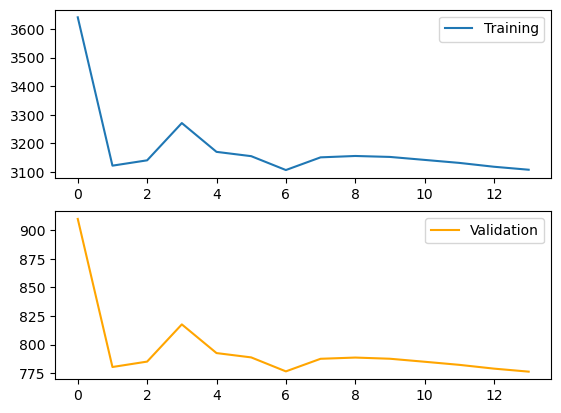

In [29]:
train_loss = checkpt['training_loss']
valid_loss = checkpt['validation_loss']
fig, axes = plt.subplots(2)
axes[0].plot(train_loss, label='Training')
axes[1].plot(valid_loss, label='Validation', c='orange')
axes[0].legend()
axes[1].legend()
plt.show()

In [ ]:
mat = np.load(f"output/output_2D_64/matrices_trained_50.npy")
print(mat)

In [ ]:
N = 256
frame = 1
scene = 'dambreak'
flags = read_flags(f"data/{scene}_N{N}_200/flags_{frame}.bin")
fluids = np.argwhere(flags == 2)
air = np.argwhere(flags == 3)

sol = load_vector(f"data/{scene}_N{N}_200/pressure_{frame}.bin")
rhs = load_vector(f"data/{scene}_N{N}_200/div_v_star_{frame}.bin")
# b = torch.load(f"data/{scene}_N{N}_200/preprocessed/{frame}/b_10.pt").numpy()
# bb = torch.load(f"data/{scene}_N{N}_200/preprocessed/{frame}/rhs.pt").reshape(1, N, N)
# image = torch.load(f"data/{scene}_N{N}_200/preprocessed/{frame}/flags.pt").reshape(1, N, N)
# r = torch.load(f"r_24.pt").reshape(1, N, N)
# for _ in range(3):
#     image = -F.max_pool2d(-image, (2, 2))
#     r = F.avg_pool2d(r, (2, 2))
#     N = N // 2
plt.imshow(flags.reshape(N, N).T[:], cmap='jet', origin='lower')
plt.colorbar()
plt.show()


In [ ]:
model = SmallSMModelDn(4)
model.load_state_dict(checkpt['model_state_dict'])

In [ ]:
b = torch.load(f"data/dambreak_N{N}_200/preprocessed/{frame}/b_100_fourier.pt")
flags = torch.load(f"data/dambreak_N{N}_200/preprocessed/{frame}/flags.pt")

In [ ]:
plt.imshow(b.numpy().reshape(N,N).T, origin='lower', cmap='jet')
b.max(), b.min()

In [ ]:
with torch.no_grad():
    bb = torch.rand_like(b).reshape(1, 1, N, N).double()
    y = model(flags.reshape(1, N, N).double(), b.reshape(1, 1, N, N).double())
    y1 = model(flags.reshape(1, N, N).double(), bb.double())
    s = 1.4*y.sum() + 2.2*y1.sum()
    ss = model(flags.reshape(1, N, N).double(), (2.2*bb+1.4*b.reshape(1, 1, N, N)).double()).sum()
s, ss

In [ ]:
plt.imshow(y[0, 4].reshape(N, N).T, origin='lower', cmap='jet')
plt.show()

In [ ]:
fluid_cells = torch.argwhere(flags.reshape(N, N) == 2).tolist()
fluid_cells

In [ ]:
pos_x, pos_y = 240, 230
print('cell in fluid:', [pos_x, pos_y] in fluid_cells)
print('upper neighbor:', [pos_x, pos_y+1] in fluid_cells)
print('lower neighbor:', [pos_x, pos_y-1] in fluid_cells)
print('left neighbor:', [pos_x-1, pos_y] in fluid_cells)
print('right neighbor:', [pos_x+1, pos_y] in fluid_cells)

In [ ]:
y.squeeze().permute((1, 2, 0))[pos_x, pos_y].reshape(3, 3)

In [ ]:
z = y[0].numpy()
nc = 0
zz = z[nc]
print(zz.min(), zz.max())
plt.imshow(zz.T, origin='lower', cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
i = 30
r = np.load(f"res_{i}.npy")
plt.clf()
plt.imshow(abs(r).reshape(N,N).T, origin='lower', cmap='jet')
plt.colorbar()
plt.show()


In [ ]:
scale = 2
flags_up = flags.reshape(N,N).repeat(scale, axis=0).repeat(scale, axis=1)

plt.imshow(flags_up.reshape(N*scale, N*scale).T, cmap='jet', origin='lower')
plt.colorbar()
plt.show()

In [ ]:
np.save(f"data/dambreak_single/{N}_{N*scale}/{frame}/flags_{frame}.npy", flags_up.ravel())

In [ ]:
from lib.discrete_laplacian import lap_with_bc, box_bd

air = np.argwhere(flags_up.ravel() == 3).ravel()
A = lap_with_bc(N*scale+2, 2, air=air, bd=box_bd(N*scale+2, 2), bd_padding=False)
A

In [ ]:
sparse.save_npz(f"data/dambreak_single/{N}_{N*scale}/{frame}/A_{frame}.npz", A)